[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1c7EiO59cmVbxdCFZRDn82I-gBi6aTPDN?usp=sharing)

# Adversarial examples generation for ConvNeXt

This notebook is a Pytorch implementation of [@stanislavfort's project](https://twitter.com/stanislavfort/status/1481263565998805002?s=20). The notebook looks at generating adversarial images to "fool" the ConvNeXt model's image classification capabilities. [ConvNeXt](https://arxiv.org/abs/2201.03545) came out earlier this year from Meta AI.

The FGSM (Fast Gradient Sign Method) is a great algorithm to attack models in a *white-box* fashion with the goal of misclassification. Noise is added to the input image (not randomly) but in a manner such that the direction is the same as the gradient of the cost function with respect to the data.

Since this notebook is just the implementation - If you want to know more about FGSM, you may refer these - 

1. https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
2. https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
3. https://arxiv.org/abs/1412.6572

The following figure summarizes the goal of this notebook - 

<img src='https://i.imgur.com/C5YKxQ2.png'>

## Install timm

Here, timm makes it easier to use the pretrained ConvNeXt model in Pytorch

In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-0byc8o8q
  Running command git clone -q https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-0byc8o8q


## Import packages

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import urllib
from PIL import Image

import torch
from torchvision import transforms

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

%matplotlib inline

In [3]:
model_names = timm.list_models('*convnext*')
model_names

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

## Load the base ConvNeXt model, trained on Imagenet-1k

In [4]:
model = timm.create_model('convnext_base', pretrained=True)
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
          (mlp): ConvMlp(
            (fc1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1))
            (norm): Identity()
            (act): GELU()
            (fc2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
            (drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm2d((128,), eps=1e-06, elementwise_affine=Tr

## Define data transforms and inverse transform for the Imagenet dataset

In [5]:
inv_data_transforms = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [6]:
config = resolve_data_config({}, model=model)
del config['interpolation']
transform = create_transform(**config)

config

{'crop_pct': 0.875,
 'input_size': (3, 224, 224),
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225)}

## Helper function to download and read the image


In [7]:
def download_image(url, filename):
    urllib.request.urlretrieve(url, filename)
    img = Image.open(filename).convert('RGB')
    return img

## Load Imagenet classes

In [8]:
def get_imagenet_classes():
    # Get imagenet class mappings
    url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
    urllib.request.urlretrieve(url, filename) 
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    return categories

## Download and transform image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])


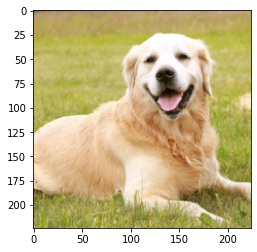

In [9]:
img = download_image("https://i.imgur.com/VLX1C6K.jpg", "dog.jpg")
img_tensor = transform(img).unsqueeze(0) # transform and add batch dimension
print(img_tensor.shape)
plt.imshow(inv_data_transforms(img_tensor)[0].permute(1,2,0))

## Initial predictions

In [10]:
with torch.no_grad():
    pred = model(img_tensor)

pred_np = pred.numpy()
probabilities = torch.nn.functional.softmax(pred[0], dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


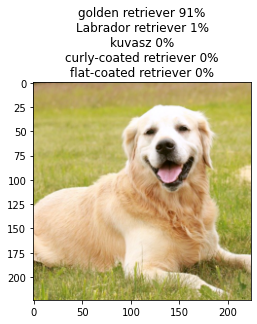

In [11]:
categories = get_imagenet_classes()

# Print top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)

title = ""
for i in range(5):
  title = title + categories[top5_catid[i]]+" "+str(int(100*top5_prob[i].item()))+"%\n"

title = title[:-1] #removing the last line break

plt.title(title)
plt.imshow(inv_data_transforms(img_tensor)[0].permute(1,2,0))
plt.show()

## FGSM Adversarial loop

In [12]:
def get_class_name(target_class):
  return categories[target_class]

In [13]:
def rescale_image(im):
  return (im - np.min(im))/(np.max(im) - np.min(im))*255

In [14]:
def get_top_5(probs):
    probs = probs.cpu().detach()

    # Print top categories per image
    top5_prob, top5_catid = torch.topk(probs, 5)
    preds = []
    for i in range(5):
        preds.append((categories[top5_catid[i]], top5_prob[i].item()))
    return preds

### Configuraions and initial settings

We want to make the model predict that the image of the Golden Retriever is actually an Ambulance (could be anything) after we are done with adding the perturbations.

In [15]:
steps = 50
use_gradient_signs_only = True #True = Fast Gradient Sign Method
LR = 1e-3

show_image_every = 5

target_class = 407
print("target class name = "+ str(get_class_name(target_class)))

target class name = ambulance


In [16]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
model = model.to(device)
_ = model.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 7.064719e-05
[('golden retriever', 0.9165482521057129), ('Labrador retriever', 0.019913990050554276), ('kuvasz', 0.00108170579187572), ('curly-coated retriever', 0.00046756817027926445), ('flat-coated retriever', 0.00045464682625606656)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


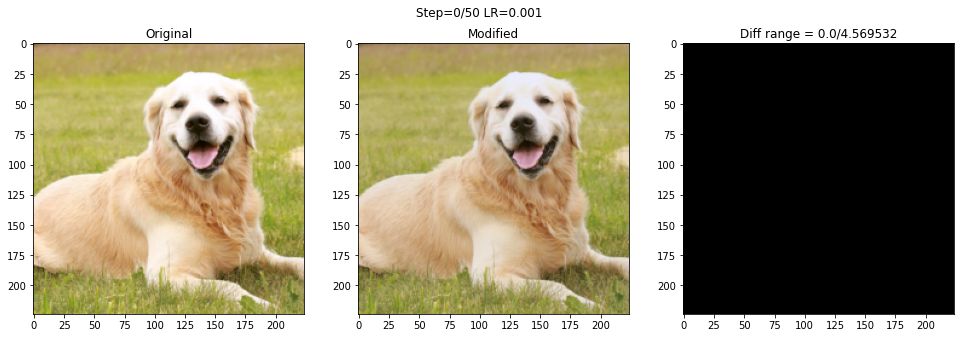

1 8.841324e-05
[('golden retriever', 0.902633786201477), ('Labrador retriever', 0.023601092398166656), ('kuvasz', 0.0011667716316878796), ('flat-coated retriever', 0.0005286746891215444), ('curly-coated retriever', 0.0004794603737536818)]
2 0.00010791109
[('golden retriever', 0.8847756385803223), ('Labrador retriever', 0.031114842742681503), ('kuvasz', 0.001196939731016755), ('flat-coated retriever', 0.0006096099386923015), ('tennis ball', 0.0005187105271033943)]
3 0.00013329991
[('golden retriever', 0.860791027545929), ('Labrador retriever', 0.0447351448237896), ('kuvasz', 0.0011985733872279525), ('flat-coated retriever', 0.0007067237747833133), ('tennis ball', 0.0006170415435917675)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 0.00016749049
[('golden retriever', 0.820862889289856), ('Labrador retriever', 0.0693625658750534), ('kuvasz', 0.00121885456610471), ('flat-coated retriever', 0.0008340543718077242), ('tennis ball', 0.0007147846044972539)]
5 0.00021624751
[('golden retriever', 0.7585315108299255), ('Labrador retriever', 0.11246299743652344), ('kuvasz', 0.0012394370278343558), ('flat-coated retriever', 0.0009830158669501543), ('tennis ball', 0.0008776816539466381)]


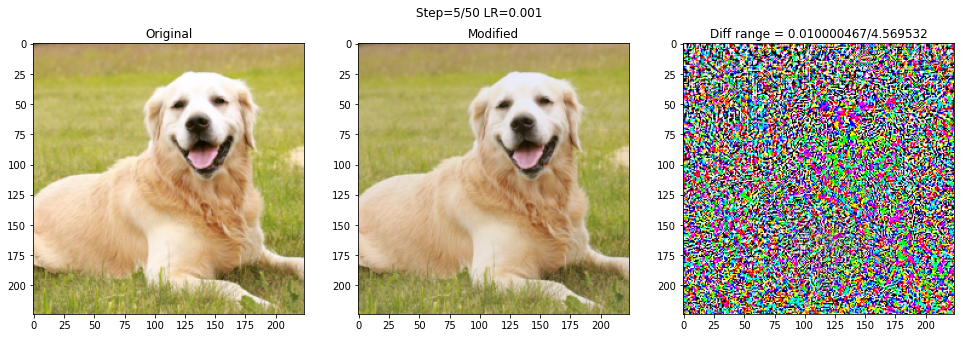

6 0.00028283495
[('golden retriever', 0.6524539589881897), ('Labrador retriever', 0.19139231741428375), ('tennis ball', 0.0012792183551937342), ('kuvasz', 0.0012058248976245522), ('flat-coated retriever', 0.0011595115065574646)]
7 0.00037576832
[('golden retriever', 0.5501189827919006), ('Labrador retriever', 0.2821349799633026), ('flat-coated retriever', 0.0012681800872087479), ('tennis ball', 0.0012266190024092793), ('kuvasz', 0.001105411909520626)]
8 0.00057989615
[('golden retriever', 0.45075100660324097), ('Labrador retriever', 0.3649361729621887), ('tennis ball', 0.0015139495953917503), ('flat-coated retriever', 0.0013244663132354617), ('Walker hound', 0.0011793940793722868)]
9 0.0013731598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('golden retriever', 0.40697336196899414), ('Labrador retriever', 0.3998907804489136), ('recreational vehicle', 0.002463063457980752), ('tennis ball', 0.001742956112138927), ('beacon', 0.0015370522160083055)]
10 0.0072756205
[('Labrador retriever', 0.41558992862701416), ('golden retriever', 0.37755563855171204), ('ambulance', 0.007275620475411415), ('recreational vehicle', 0.006261620670557022), ('police van', 0.0034079113975167274)]


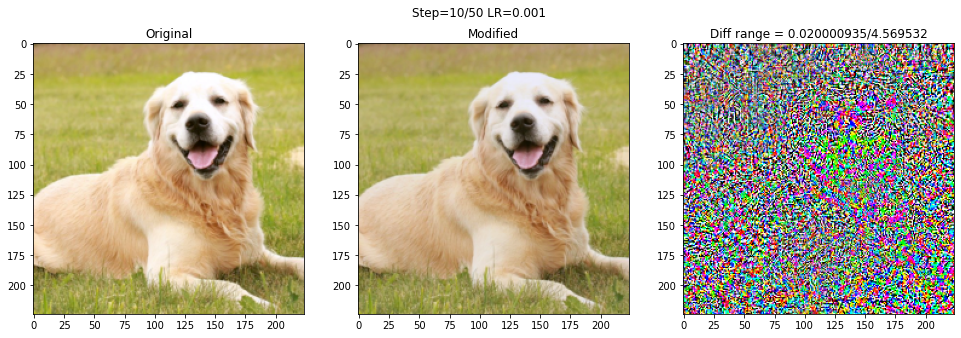

11 0.058803916
[('Labrador retriever', 0.39117351174354553), ('golden retriever', 0.3316202759742737), ('ambulance', 0.05880391597747803), ('police van', 0.027217572554945946), ('recreational vehicle', 0.010098378174006939)]
12 0.1853551
[('Labrador retriever', 0.3191089332103729), ('golden retriever', 0.2688097059726715), ('ambulance', 0.18535509705543518), ('police van', 0.07083340734243393), ('recreational vehicle', 0.006612739991396666)]
13 0.31674668
[('ambulance', 0.31674668192863464), ('golden retriever', 0.25298407673835754), ('Labrador retriever', 0.24570924043655396), ('police van', 0.04223816841840744), ('recreational vehicle', 0.0057385945692658424)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14 0.46369156
[('ambulance', 0.4636915624141693), ('golden retriever', 0.20080316066741943), ('Labrador retriever', 0.18172325193881989), ('police van', 0.02976735681295395), ('recreational vehicle', 0.004011884797364473)]
15 0.58635604
[('ambulance', 0.5863560438156128), ('golden retriever', 0.15201587975025177), ('Labrador retriever', 0.13306474685668945), ('police van', 0.017415836453437805), ('recreational vehicle', 0.003945304546505213)]


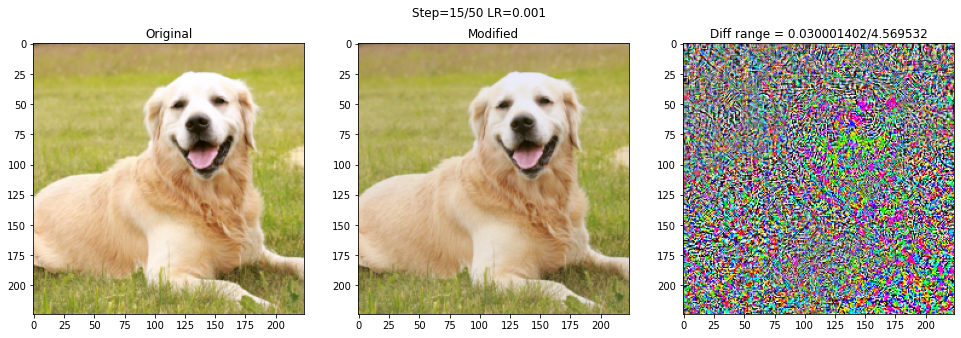

16 0.5984271
[('ambulance', 0.5984271168708801), ('golden retriever', 0.14330029487609863), ('Labrador retriever', 0.13715648651123047), ('police van', 0.018439020961523056), ('minibus', 0.0032169099431484938)]
17 0.6717185
[('ambulance', 0.6717184782028198), ('golden retriever', 0.1150992289185524), ('Labrador retriever', 0.103741355240345), ('police van', 0.009729616343975067), ('minibus', 0.0033356747590005398)]
18 0.74999475
[('ambulance', 0.7499947547912598), ('golden retriever', 0.0855075865983963), ('Labrador retriever', 0.07382256537675858), ('police van', 0.01023684162646532), ('recreational vehicle', 0.0016270371852442622)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19 0.824696
[('ambulance', 0.8246960043907166), ('golden retriever', 0.05833176150918007), ('Labrador retriever', 0.04817979782819748), ('police van', 0.00532164704054594), ('minibus', 0.0013444713549688458)]
20 0.8691092
[('ambulance', 0.8691092133522034), ('golden retriever', 0.04036642611026764), ('Labrador retriever', 0.030936257913708687), ('police van', 0.00429554283618927), ('tennis ball', 0.0011098193936049938)]


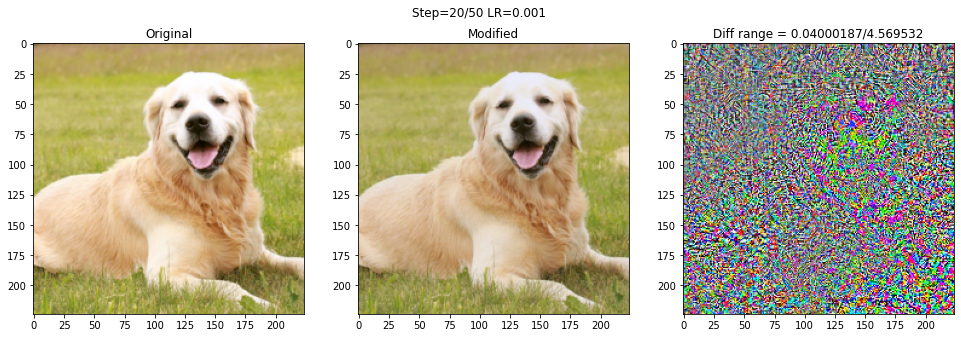

21 0.9070842
[('ambulance', 0.9070842266082764), ('golden retriever', 0.023678293451666832), ('Labrador retriever', 0.020162051543593407), ('police van', 0.0020047668367624283), ('tennis ball', 0.0009026554762385786)]
22 0.9190937
[('ambulance', 0.9190937280654907), ('golden retriever', 0.021397007629275322), ('Labrador retriever', 0.015420492738485336), ('police van', 0.0019806185737252235), ('tennis ball', 0.0008122146828100085)]
23 0.91940296
[('ambulance', 0.9194029569625854), ('golden retriever', 0.01654425822198391), ('Labrador retriever', 0.015569739043712616), ('police van', 0.0020958075765520334), ('vending machine', 0.0010191454784944654)]
24 0.9433232
[('ambulance', 0.9433231949806213), ('golden retriever', 0.011819349601864815), ('Labrador retriever', 0.008529541082680225), ('police van', 0.0009106066427193582), ('Brittany spaniel', 0.0007031604764051735)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25 0.94590086
[('ambulance', 0.9459008574485779), ('golden retriever', 0.00934669841080904), ('Labrador retriever', 0.008669446222484112), ('police van', 0.0010417115408927202), ('tennis ball', 0.0007275052485056221)]


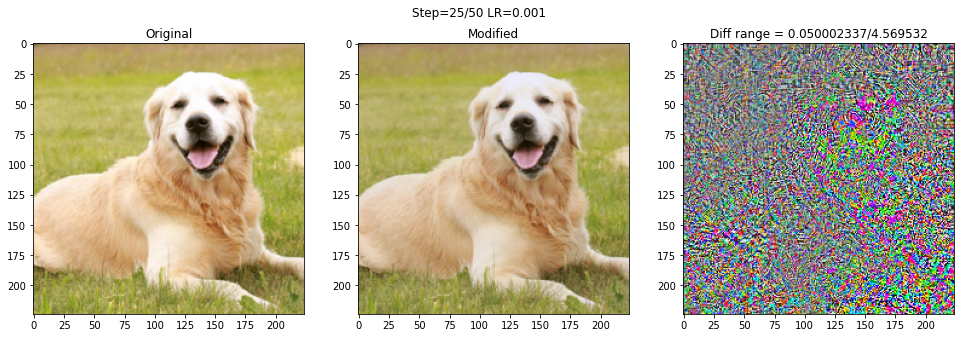

26 0.9558407
[('ambulance', 0.9558407068252563), ('golden retriever', 0.007217884995043278), ('Labrador retriever', 0.005436252802610397), ('police van', 0.0007506755646318197), ('Brittany spaniel', 0.0006207217229530215)]
27 0.96099246
[('ambulance', 0.9609924554824829), ('Labrador retriever', 0.006059099920094013), ('golden retriever', 0.005546687636524439), ('police van', 0.0008813265012577176), ('tennis ball', 0.0004602283297572285)]
28 0.9650626
[('ambulance', 0.9650626182556152), ('golden retriever', 0.004700066056102514), ('Labrador retriever', 0.003767933463677764), ('Brittany spaniel', 0.0006115662399679422), ('police van', 0.000524094037245959)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29 0.9698343
[('ambulance', 0.9698343276977539), ('Labrador retriever', 0.004388716537505388), ('golden retriever', 0.0037437949795275927), ('police van', 0.0006653490127064288), ('moving van', 0.00040019722655415535)]
30 0.97302914
[('ambulance', 0.9730291366577148), ('golden retriever', 0.0026771980337798595), ('Labrador retriever', 0.0024001740384846926), ('Brittany spaniel', 0.0004943009116686881), ('police van', 0.0004899872583337128)]


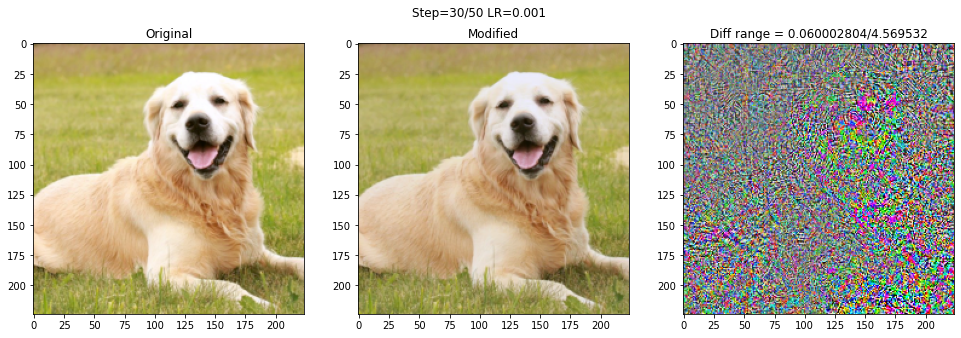

31 0.97649825
[('ambulance', 0.9764982461929321), ('Labrador retriever', 0.002939905971288681), ('golden retriever', 0.0022960042115300894), ('police van', 0.000716618204023689), ('Brittany spaniel', 0.00032680167350918055)]
32 0.97930145
[('ambulance', 0.9793014526367188), ('Labrador retriever', 0.0020053107291460037), ('golden retriever', 0.00192587124183774), ('Brittany spaniel', 0.0004378693993203342), ('police van', 0.000411894463468343)]
33 0.98255724
[('ambulance', 0.9825572371482849), ('Labrador retriever', 0.0016659762477502227), ('golden retriever', 0.0013862930936738849), ('police van', 0.0005311704007908702), ('Brittany spaniel', 0.00029214078676886857)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34 0.98450655
[('ambulance', 0.9845065474510193), ('Labrador retriever', 0.001260192133486271), ('golden retriever', 0.0011546271853148937), ('police van', 0.00036913008079864085), ('Brittany spaniel', 0.0002960850251838565)]
35 0.9862487
[('ambulance', 0.9862486720085144), ('Labrador retriever', 0.0013869770336896181), ('golden retriever', 0.0008925151778385043), ('police van', 0.0006146036321297288), ('Brittany spaniel', 0.00020675090490840375)]


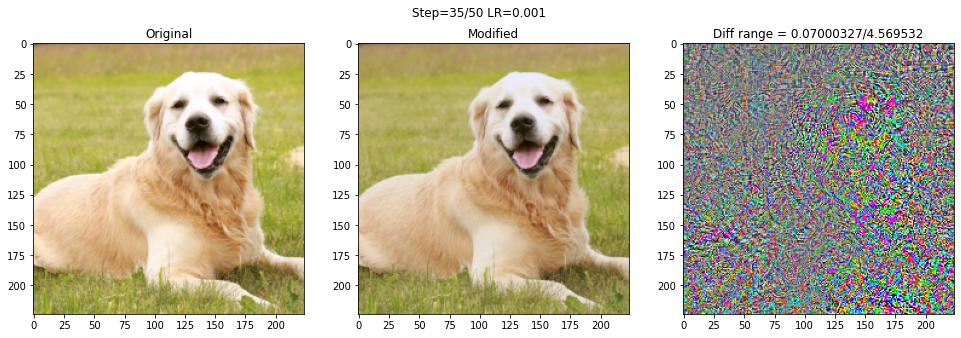

36 0.98853266
[('ambulance', 0.9885326623916626), ('Labrador retriever', 0.0009070796077139676), ('golden retriever', 0.0006124773644842207), ('police van', 0.0002632383839227259), ('Brittany spaniel', 0.00023976857482921332)]
37 0.99021894
[('ambulance', 0.9902189373970032), ('Labrador retriever', 0.0007941171061247587), ('golden retriever', 0.0004717449482996017), ('police van', 0.0004076015902683139), ('English setter', 0.00019258548854850233)]
38 0.9912321
[('ambulance', 0.9912320971488953), ('Labrador retriever', 0.0006559789762832224), ('golden retriever', 0.00040260644163936377), ('police van', 0.00023330826661549509), ('English setter', 0.0002083708968712017)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39 0.9927499
[('ambulance', 0.9927499294281006), ('Labrador retriever', 0.0005832879105582833), ('police van', 0.00043340964475646615), ('golden retriever', 0.00022738880943506956), ('English setter', 0.00016678184329066426)]
40 0.9933617
[('ambulance', 0.9933617115020752), ('Labrador retriever', 0.0005561994039453566), ('golden retriever', 0.0002618937287479639), ('police van', 0.00019089529814664274), ('English setter', 0.00016046949895098805)]


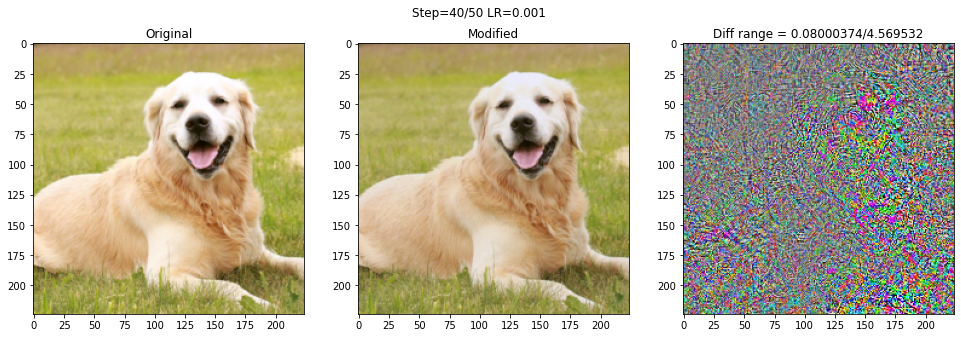

41 0.99476576
[('ambulance', 0.9947657585144043), ('Labrador retriever', 0.0004398103628773242), ('police van', 0.00029310653917491436), ('golden retriever', 0.00014766740787308663), ('English setter', 0.0001226663589477539)]
42 0.9951563
[('ambulance', 0.9951562881469727), ('Labrador retriever', 0.0003516656579449773), ('police van', 0.00018947452190332115), ('golden retriever', 0.0001443984656361863), ('English setter', 0.00012913056707475334)]
43 0.9939183
[('ambulance', 0.9939182996749878), ('Labrador retriever', 0.0005739895859733224), ('police van', 0.0004821297770831734), ('monarch', 0.00016827796935103834), ('golden retriever', 0.00014070654287934303)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44 0.99624664
[('ambulance', 0.9962466359138489), ('Labrador retriever', 0.0002884475397877395), ('police van', 0.00012255689944140613), ('golden retriever', 9.761717956280336e-05), ('English setter', 8.64453540998511e-05)]
45 0.9964824
[('ambulance', 0.9964823722839355), ('police van', 0.0003133731079287827), ('Labrador retriever', 0.00026075050118379295), ('menu', 8.586937474319711e-05), ('English setter', 7.972944877110422e-05)]


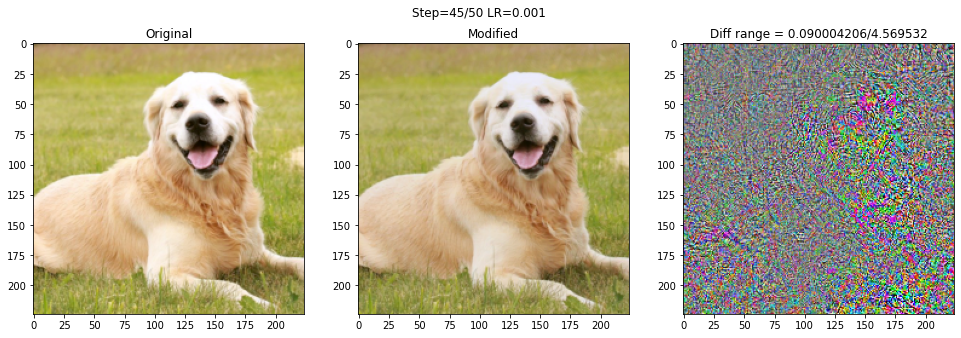

46 0.99705064
[('ambulance', 0.9970506429672241), ('Labrador retriever', 0.00019711970526259392), ('police van', 0.00010793298861244693), ('English setter', 7.571702735731378e-05), ('golden retriever', 7.080152863636613e-05)]
47 0.99744177
[('ambulance', 0.9974417686462402), ('police van', 0.0002274623402627185), ('Labrador retriever', 0.0001783560001058504), ('menu', 8.065904694376513e-05), ('English setter', 5.499860708368942e-05)]
48 0.99770015
[('ambulance', 0.9977001547813416), ('Labrador retriever', 0.00014074912178330123), ('police van', 9.413623047294095e-05), ('English setter', 5.145838440512307e-05), ('golden retriever', 4.943247768096626e-05)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49 0.99783
[('ambulance', 0.9978299736976624), ('police van', 0.00027062720619142056), ('Labrador retriever', 0.00015258709026966244), ('menu', 6.676534394500777e-05), ('monarch', 4.337842619861476e-05)]


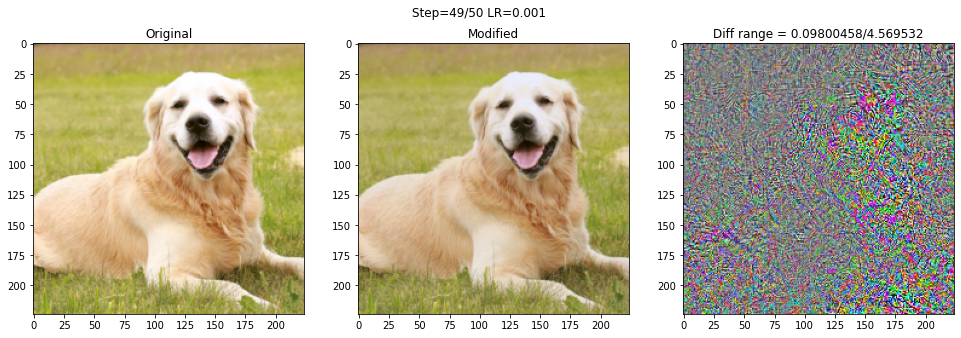

In [17]:
img = download_image("https://i.imgur.com/VLX1C6K.jpg", "dog.jpg")
input_img = transform(img).unsqueeze(0) # transform and add batch dimension
input_img = input_img.to(device)

image_input_start_np = input_img.cpu().detach()
input_img.requires_grad = True

preds_list = []

for step in range(steps):
    pred = model(input_img)
    probs = torch.nn.functional.softmax(pred[0], dim=0)

    if step == 0:
        original_label = np.argmax(probs.cpu().detach().numpy())

    print(step, probs.cpu().detach().numpy()[target_class])
    print(get_top_5(probs))

    if show_image_every is not None and (step % show_image_every == 0 or step == steps-1):
      plt.figure(figsize = (3*5.5,5))

      plt.suptitle("Step="+str(step)+"/"+str(steps)+" LR="+str(LR))

      plt.subplot(1,3,1)
      plt.title("Original")
      plt.imshow(
          inv_data_transforms(image_input_start_np)[0].permute(1,2,0)
        )

      plt.subplot(1,3,2)
      plt.title("Modified")
      plt.imshow(
          np.round(
              rescale_image(inv_data_transforms(input_img.cpu().detach())[0].permute(1,2,0).numpy())
          ).astype(np.uint8)
        )

      img_diff = input_img.cpu().detach().numpy() - image_input_start_np.numpy()
      diff_range = np.max(img_diff) - np.min(img_diff)
      img_range = np.max(image_input_start_np.numpy()) - np.min(image_input_start_np.numpy())

      plt.subplot(1,3,3)
      plt.title("Diff range = "+str(diff_range)+"/"+str(img_range))
      plt.imshow(
          np.transpose(((img_diff - np.min(img_diff))/diff_range*255)[0].astype(np.uint8), (1,2,0))
          )

      plt.show()

    preds_list.append([probs.cpu().detach().numpy()])
    selected_class_pred = probs[target_class]

    image_gradient = torch.autograd.grad(selected_class_pred, input_img)[0]

    if use_gradient_signs_only:
        image_gradient = torch.gt(image_gradient, 0).float()*2.0-1.0

    input_img = input_img + LR*image_gradient

preds_np = np.concatenate(preds_list,axis=0)

## Class predictions plot

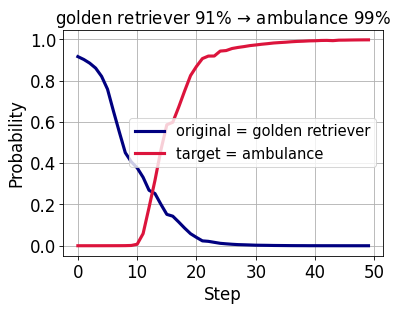

In [18]:
plt.figure(figsize = (5.5,4), dpi=75)

title = get_class_name(original_label) + " " + str(int(100*preds_np[0,original_label]))+"%"
title = title + " $\\to$"
title = title + " " + get_class_name(target_class) + " " + str(int(100*preds_np[-1,target_class]))+"%"

plt.title(title,fontsize=16)

plt.plot(preds_np[:,original_label],linewidth=3,color="navy",label="original = "+get_class_name(original_label))
plt.plot(preds_np[:,target_class],linewidth=3,color="crimson",label="target = "+get_class_name(target_class))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=14)

plt.xlabel("Step",fontsize=16)
plt.ylabel("Probability",fontsize=16)

plt.grid(True)

plt.show()

## Final Summary

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


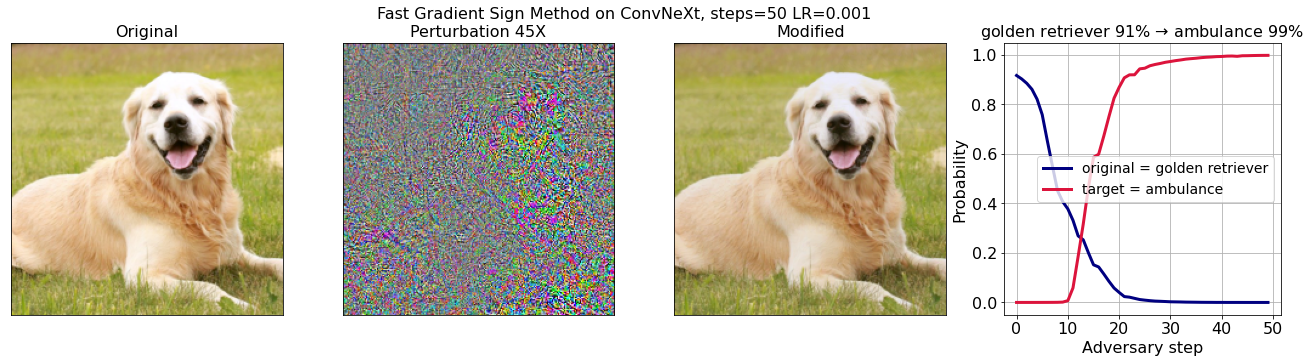

In [19]:
plt.figure(figsize = (4*5.7,5))

plt.suptitle("Fast Gradient Sign Method on ConvNeXt, steps="+str(steps)+" LR="+str(LR),fontsize=16)

plt.subplot(1,4,1)
plt.title("Original",fontsize=16)
plt.imshow(
          inv_data_transforms(image_input_start_np)[0].permute(1,2,0)
        )

plt.xticks([],[])
plt.yticks([],[])


plt.subplot(1,4,3)
plt.title("Modified",fontsize=16)
plt.imshow(
        np.round(
            rescale_image(inv_data_transforms(input_img.cpu().detach())[0].permute(1,2,0).numpy())
        ).astype(np.uint8)
    )

img_diff = input_img.cpu().detach().numpy() - image_input_start_np.numpy()
diff_range = np.max(img_diff) - np.min(img_diff)
img_range = np.max(image_input_start_np.numpy()) - np.min(image_input_start_np.numpy())

plt.xticks([],[])
plt.yticks([],[])


plt.subplot(1,4,2)
plt.title("Perturbation "+str(int(img_range/diff_range))+"X",fontsize=16)
plt.imshow(
        np.transpose(((img_diff - np.min(img_diff))/diff_range*255)[0].astype(np.uint8), (1,2,0))
        )

plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,4,4)

title = get_class_name(original_label) + " " + str(int(100*preds_np[0,original_label]))+"%"
title = title + " $\\to$"
title = title + " " + get_class_name(target_class) + " " + str(int(100*preds_np[-1,target_class]))+"%"

plt.title(title,fontsize=16)

plt.plot(preds_np[:,original_label],linewidth=3,color="navy",label="original = "+get_class_name(original_label))
plt.plot(preds_np[:,target_class],linewidth=3,color="crimson",label="target = "+get_class_name(target_class))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=14)

plt.xlabel("Adversary step",fontsize=16)
plt.ylabel("Probability",fontsize=16)

plt.grid(True)


plt.show()